In [2]:
%pip install -U pip
%pip install accelerate==0.20.3
%pip install appdirs==1.4.4
%pip install bitsandbytes==0.37.2
%pip install datasets==2.10.1
%pip install fire==0.5.0
%pip install git+https://github.com/huggingface/peft.git
%pip install git+https://github.com/huggingface/transformers.git
%pip install torch==2.0.0
%pip install sentencepiece==0.1.97
%pip install tensorboardX==2.6
%pip install gradio==3.23.0

Defaulting to user installation because normal site-packages is not writeable
  Using cached pip-23.1.2-py3-none-any.whl (2.1 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached accelerate-0.18.0-py3-none-any.whl (215 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached bitsandbytes-0.37.2-py3-none-any.whl (84.2 MB)
Note: you may need to restart the kernel to use updated packages.
Defaulting to user 

In [2]:
import transformers
import textwrap
from transformers import LlamaTokenizer, LlamaForCausalLM
import os
import sys
from typing import List
 
from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
)
 
import fire
import torch
from datasets import load_dataset
import pandas as pd
 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams
 
%matplotlib inline
sns.set(rc={'figure.figsize':(10, 7)})
sns.set(rc={'figure.dpi':100})
sns.set(style='white', palette='muted', font_scale=1.2)
 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

/home/tj/anaconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA SETUP: CUDA runtime path found: /home/tj/anaconda3/envs/torch/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /home/hb/.local/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda113.so...


'cuda'

In [3]:
df = pd.read_csv("hate_speech.csv")
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


0 - hate speech

1 - offensive language

2 - neither

In [4]:
def class_score_to_name(score: int):
    if score == 0:
        return "Hate speech"
    elif score == 1:
        return "offensive language"
    return "Neither"
 
dataset_data = [
    {
        "instruction": "Classify the tweet.",
        "input": row_dict["tweet"],
        "output": class_score_to_name(row_dict["class"])
    }
    for row_dict in df.to_dict(orient="records")
]
 
dataset_data[0]

{'instruction': 'Classify the tweet.',
 'input': "!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...",
 'output': 'Neither'}

In [5]:
import json
with open("alpaca-hatespeech-dataset.json", "w") as f:
   json.dump(dataset_data, f)

In [6]:
BASE_MODEL = 'decapoda-research/llama-7b-hf'
 
model = LlamaForCausalLM.from_pretrained(
    BASE_MODEL,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map='auto',
)
 
tokenizer = LlamaTokenizer.from_pretrained(BASE_MODEL)
 
tokenizer.pad_token_id = (0)
tokenizer.padding_side = 'left'

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.
Loading checkpoint shards: 100%|██████████| 33/33 [00:14<00:00,  2.20it/s]
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.


In [7]:
data = load_dataset('json', data_files='alpaca-hatespeech-dataset.json')
data['train']

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 732.37it/s]


Dataset json downloaded and prepared to /home/hb/.cache/huggingface/datasets/json/default-291249fb4be999e6/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 432.94it/s]


Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 24783
})

In [8]:
CUTOFF_LEN = 256

def generate_prompt(data_point):
    return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.  # noqa: E501
### Instruction:
{data_point["instruction"]}
### Input:
{data_point["input"]}
### Response:
{data_point["output"]}"""
 
 
def tokenize(prompt, add_eos_token=True):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=CUTOFF_LEN,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < CUTOFF_LEN
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)
 
    result["labels"] = result["input_ids"].copy()
 
    return result
 
def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)
    tokenized_full_prompt = tokenize(full_prompt)
    return tokenized_full_prompt

In [9]:
train_val = data["train"].train_test_split(
    test_size=200, shuffle=True, seed=42
)
train_data = (
    train_val["train"].map(generate_and_tokenize_prompt)
)
val_data = (
    train_val["test"].map(generate_and_tokenize_prompt)
)

In [10]:
LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT= 0.05
LORA_TARGET_MODULES = [
    "q_proj",
    "v_proj",
]
 
BATCH_SIZE = 128
MICRO_BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE // MICRO_BATCH_SIZE
LEARNING_RATE = 3e-4
TRAIN_STEPS = 300
OUTPUT_DIR = "hate_speech_exp"

In [11]:
model = prepare_model_for_int8_training(model)
config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)
model.print_trainable_parameters()

/home/hb/.local/lib/python3.8/site-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199


In [12]:
training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=100,
    max_steps=TRAIN_STEPS,
    learning_rate=LEARNING_RATE,
    fp16=True,
    logging_steps=10,
    optim="adamw_torch",
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    save_steps=50,
    output_dir=OUTPUT_DIR,
    save_total_limit=3,
    load_best_model_at_end=True,
    report_to="tensorboard"
)

In [13]:
data_collator = transformers.DataCollatorForSeq2Seq(
    tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
)

In [14]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=training_arguments,
    data_collator=data_collator
)
model.config.use_cache = False
old_state_dict = model.state_dict
model.state_dict = (
    lambda self, *_, **__: get_peft_model_state_dict(
        self, old_state_dict()
    )
).__get__(model, type(model))
 
model = torch.compile(model)
 
trainer.train()
model.save_pretrained(OUTPUT_DIR)

/home/hb/.local/lib/python3.8/site-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss


/home/hb/.local/lib/python3.8/site-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/hb/.local/lib/python3.8/site-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/hb/.local/lib/python3.8/site-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/hb/.local/lib/python3.8/site-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to 

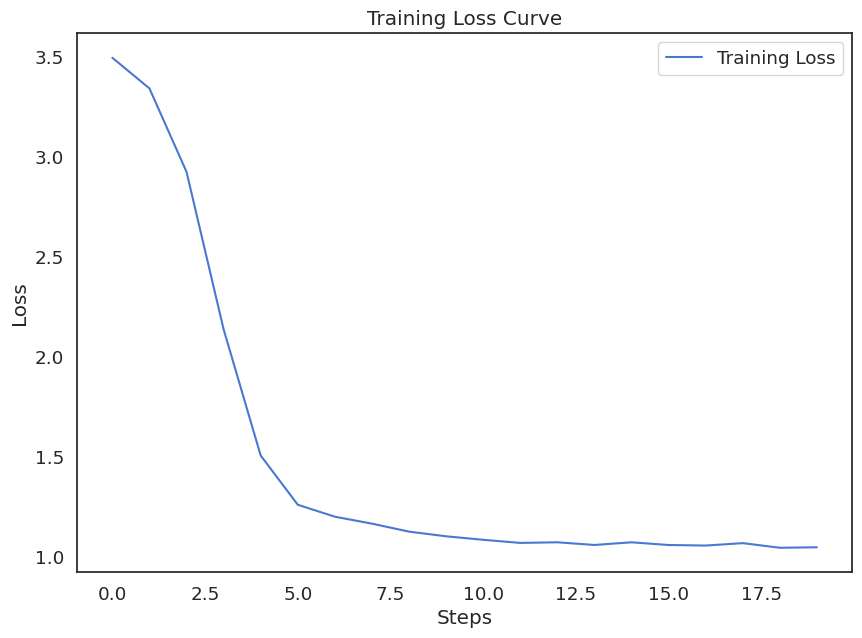

In [22]:
import json
import matplotlib.pyplot as plt

with open('hate_speech_exp/checkpoint-200/trainer_state.json', 'r') as f:
    trainer_state = json.load(f)


log_history = trainer_state['log_history']
train_loss_values = [entry['loss'] for entry in log_history if 'loss' in entry]
train_acc_values = [entry['accuracy'] for entry in log_history if 'accuracy' in entry]

plt.plot(train_loss_values, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()
